# Quantum Prisoner’s Dilemma (EWL) — Notebook

This notebook implements the Eisert–Wilkens–Lewenstein (EWL) quantization of the Prisoner’s Dilemma.
It includes: implementation of the entangling operator J(γ), the general local strategy U(θ,φ),
a `play_game` function using statevector simulation, and visualization of payoffs for several entanglement values γ.

Requirements: `qiskit`, `numpy`, `matplotlib`.

Created on: 2025-11-17 11:24:44 UTC


# Quantum Prisoner’s Dilemma — EWL Quantum Game Tutorial

This notebook implements the **Eisert–Wilkens–Lewenstein (EWL)** quantization of the classic Prisoner’s Dilemma.

You will learn:

- How quantum strategies are represented using unitary matrices  
- How entanglement modifies classical game-theoretic equilibria  
- How to compute expected payoffs from quantum measurements  
- How to visualize payoff landscapes  
- How to explore new equilibria created by quantum strategies  

We use **NumPy** for matrix simulation (fast, exact, no noise).


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
plt.rcParams['figure.figsize'] = (6,4)


# 1. Entangling Operator 𝐽(γ)

EWL begins with an entangling gate \( J(\gamma) \):

\[
J(\gamma) = \cos(\gamma/2) I\otimes I + i\sin(\gamma/2)\, X\otimes X
\]

- γ = 0 → classical game  
- γ = π/2 → maximally entangled  

This creates correlations that enable **quantum strategies** to outperform classical ones.


In [17]:
def J_matrix(gamma):
    """Return 4x4 matrix for J(gamma) = cos(g/2) I + i sin(g/2) X⊗X"""
    c = np.cos(gamma/2)
    s = np.sin(gamma/2)
    X = np.array([[0,1],[1,0]], dtype=complex)
    I = np.eye(2, dtype=complex)
    XX = np.kron(X, X)
    J = c * np.kron(I, I) + 1j * s * XX
    return J


# 2. Strategy Operator 𝑈(θ,φ)

Each player chooses a quantum strategy:

\[
U(\theta,\phi) =
\begin{pmatrix}
e^{i\phi}\cos(\theta/2) & \sin(\theta/2) \\
-\sin(\theta/2) & e^{-i\phi}\cos(\theta/2)
\end{pmatrix}
\]

Special cases:

| Strategy | θ | φ | Meaning |
|---------|---|---|---------|
| C (Cooperate) | 0 | 0 | Identity |
| D (Defect) | π | 0 | iX (classical defect) |


In [18]:
def U_matrix(theta, phi):
    """Return 2x2 strategy matrix U(theta,phi) as in EWL.
    U = [[e^{i phi} cos(theta/2), sin(theta/2)], [-sin(theta/2), e^{-i phi} cos(theta/2)]]
    """
    a = np.exp(1j * phi) * np.cos(theta/2)
    b = np.sin(theta/2)
    c = -np.sin(theta/2)
    d = np.exp(-1j * phi) * np.cos(theta/2)
    return np.array([[a, b],[c, d]], dtype=complex)

# 3. Running One Quantum Game

The sequence is:

1. Start in \(|00\rangle\)
2. Apply entangling operation \(J(\gamma)\)
3. Apply each player's strategy unitary
4. Apply \(J^\dagger\) (de-entangle)
5. Measure to get classical outcomes
6. Convert to payoffs using standard Prisoner’s Dilemma table

Payoff table:

| Outcome | Meaning | A payoff | B payoff |
|---------|---------|----------|----------|
| 00 | both cooperate | 3 | 3 |
| 01 | A cooperates, B defects | 0 | 5 |
| 10 | A defects, B cooperates | 5 | 0 |
| 11 | both defect | 1 | 1 |


In [19]:

def play_game(theta_A, phi_A, theta_B, phi_B, gamma, payoff_table=None):
    """Play one EWL game using statevector simulation. Returns outcome probabilities and (payoffA, payoffB).
    payoff_table should be dict mapping bitstring to (payoffA, payoffB) for outcomes '00','01','10','11'.
    Qubit order: [A, B] with 0 -> A, 1 -> B when forming kron.
    """
    if payoff_table is None:
        # Standard PD payoffs (R, S, T, P) = (3, 0, 5, 1)
        payoff_table = {
            '00': (3, 3),  # C,C -> both get R
            '01': (0, 5),  # C,D -> A gets S, B gets T
            '10': (5, 0),  # D,C -> A gets T, B gets S
            '11': (1, 1)   # D,D -> both get P
        }
    # Build full unitary: J * (U_A ⊗ U_B) * J^
    J = J_matrix(gamma)
    U_A = U_matrix(theta_A, phi_A)
    U_B = U_matrix(theta_B, phi_B)
    Ufull = np.kron(U_A, U_B)
    # Full op: J * Ufull * J^
    full = J @ Ufull @ np.conjugate(J.T)
    # Apply to |00> state
    psi0 = np.array([1,0,0,0], dtype=complex)
    psi_final = full @ psi0
    # Probabilities
    probs = { '00': np.abs(psi_final[0])**2,
              '01': np.abs(psi_final[1])**2,
              '10': np.abs(psi_final[2])**2,
              '11': np.abs(psi_final[3])**2 }
    payoffA = sum(probs[b] * payoff_table[b][0] for b in probs)
    payoffB = sum(probs[b] * payoff_table[b][1] for b in probs)
    return probs, (payoffA, payoffB)


# 4. Classical vs Quantum Strategies

We compare:
- C = U(0,0)
- D = U(π,0)

across several **entanglement strengths γ**.

This shows how entanglement changes expected payoffs even for classical strategies.


In [20]:
# Classical strategies: C = U(0,0) (cooperate), D = U(pi,0) (defect)
theta_C, phi_C = 0.0, 0.0
theta_D, phi_D = np.pi, 0.0
for gamma in [0, np.pi/8, np.pi/4, np.pi/2]:
    p_CC, pay_CC = play_game(theta_C, phi_C, theta_C, phi_C, gamma)
    p_DD, pay_DD = play_game(theta_D, phi_D, theta_D, phi_D, gamma)
    print(f"gamma={gamma:.3f}: C,C pay={pay_CC}, D,D pay={pay_DD}")


gamma=0.000: C,C pay=(np.float64(3.0), np.float64(3.0)), D,D pay=(np.float64(1.0), np.float64(1.0))
gamma=0.393: C,C pay=(np.float64(3.0), np.float64(3.0)), D,D pay=(np.float64(1.0), np.float64(1.0))
gamma=0.785: C,C pay=(np.float64(3.0), np.float64(3.0)), D,D pay=(np.float64(1.0), np.float64(1.0))
gamma=1.571: C,C pay=(np.float64(3.0000000000000013), np.float64(3.0000000000000013)), D,D pay=(np.float64(1.0000000000000004), np.float64(1.0000000000000004))


### Symmetric Strategy Payoff Calculation

Here we sweep θ from 0 to π and assume both players use the same strategy \( U(\theta,0) \).  
For each entanglement value γ, we compute Player A and B’s expected payoffs and store them for plotting.


In [21]:
import numpy as np
thetas = np.linspace(0, np.pi, 201)
gammas = [0.0, np.pi/8, np.pi/4, np.pi/2]
results = {}
for gamma in gammas:
    payoffs_A = []
    payoffs_B = []
    for th in thetas:
        _, (pA, pB) = play_game(th, 0.0, th, 0.0, gamma)
        payoffs_A.append(pA)
        payoffs_B.append(pB)
    results[gamma] = (np.array(payoffs_A), np.array(payoffs_B))
print('Computed symmetric-payoff curves for gamma values')


Computed symmetric-payoff curves for gamma values


# 5. Symmetric Strategy Curve

We now let **both players choose the SAME strategy**:

\[
U(\theta,0)
\]

and sweep θ from 0 → π.

This reveals:
- New quantum equilibria  
- Quantum advantage over classical outcomes  
- How strategy payoffs deform with entanglement  


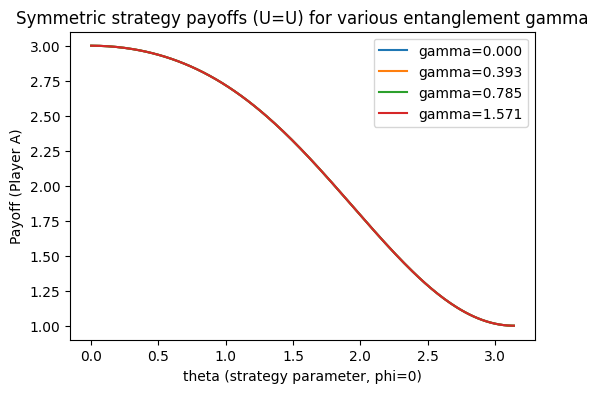

In [22]:
plt.figure()
for gamma in results:
    pa, pb = results[gamma]
    plt.plot(thetas, pa, label=f'gamma={gamma:.3f}')
plt.xlabel('theta (strategy parameter, phi=0)')
plt.ylabel('Payoff (Player A)')
plt.legend()
plt.title('Symmetric strategy payoffs (U=U) for various entanglement gamma')
plt.show()


# 6. 2D Payoff Heatmap

We allow:

- Player A varies θ_A  
- Player B varies θ_B  

This produces a **full payoff landscape**, allowing you to visually identify:

- Best-response curves  
- Nash equilibrium locations  
- Regions where quantum strategies outperform classical ones  


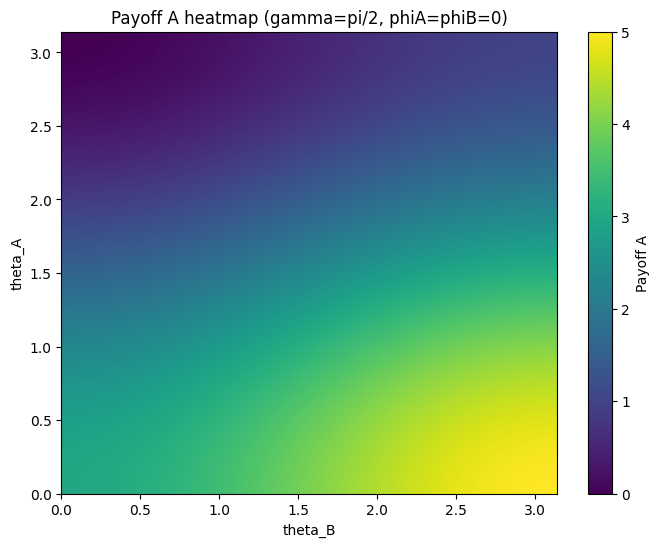

In [23]:
import matplotlib.pyplot as plt
thetasA = np.linspace(0, np.pi, 201)
thetasB = np.linspace(0, np.pi, 201)
def payoff_matrix_for_gamma(gamma, phiA=0, phiB=0):
    PA = np.zeros((len(thetasA), len(thetasB)))
    PB = np.zeros_like(PA)
    for i, ta in enumerate(thetasA):
        for j, tb in enumerate(thetasB):
            _, (pA, pB) = play_game(ta, phiA, tb, phiB, gamma)
            PA[i,j] = pA
            PB[i,j] = pB
    return PA, PB

gamma = np.pi/2
PA, PB = payoff_matrix_for_gamma(gamma)
plt.figure(figsize=(8,6))
plt.imshow(PA, extent=[0, np.pi, 0, np.pi], origin='lower', aspect='auto')
plt.colorbar(label='Payoff A')
plt.xlabel('theta_B')
plt.ylabel('theta_A')
plt.title('Payoff A heatmap (gamma=pi/2, phiA=phiB=0)')
plt.show()


## Conclusion

### 1. Symmetric Strategy Plot (U = U)

The first graph shows Player A's payoff when both players use the same strategy U(θ, 0).  
The payoff smoothly decreases from:

- Payoff = 3 at θ = 0   (both players cooperate)
- Payoff = 1 at θ = π   (both players defect)

All curves for different entanglement values γ look almost identical.
This means entanglement does not noticeably change the payoff when both players pick
the same type of strategy.

**Conclusion:**  
Under symmetric play, the quantum version behaves almost the same as the classical
Prisoner’s Dilemma.

---

### 2. Payoff Heatmap for γ = π/2

Here, Player A’s payout is plotted as both players vary their strategy angles independently.

Key points:

- Maximum payoff occurs when:
  - Player A chooses θ_A ≈ π  (A defects)
  - Player B chooses θ_B ≈ 0  (B cooperates)
  - This corresponds to the classical “temptation” payoff T = 5.

- Minimum payoff occurs when:
  - Player A chooses θ_A ≈ 0   (A cooperates)
  - Player B chooses θ_B ≈ π   (B defects)
  - This matches the classical “sucker's payoff” S = 0.

- The entire plot shows a smooth gradient as strategies move between cooperation
  and defection.

**Conclusion:**  
Quantum entanglement makes the payoff surface smooth, but the extreme outcomes
remain the same:  
T > R > P > S  
(where T = 5, R = 3, P = 1, S = 0).

---

### Overall Summary

- Symmetric strategies do not benefit from adding quantum entanglement.
- When players choose different strategies, the quantum model gives a smooth
  “continuous” payoff landscape.
- The fundamental Prisoner’s Dilemma behavior remains unchanged unless players use
  additional quantum phases (phi ≠ 0), which were not included in these graphs.
